<a href="https://colab.research.google.com/github/trudramukerji14/CLIP_ZeroShot_AntsBees/blob/main/CLIP_ZeroShot_AntsBees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we use [CLIP](https://openai.com/index/clip/) to classify the popular hymenoptera dataset (see for example this [tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)).

**CLIP** is a neural network developed by researchers at OpenAI that is trained using aigned images and text from the internet. This model represents a dramatic shift from training on gold-standard labeled datasets to training on prevalent amounts of images from the web which are "naturally" annotated by text captions.

The model utilizes a vision and text transformer to encode the images and texts and is trained by maximizing the cosine similarity (dot product) between images and texts that are likely to be paired together. For more details, please see the link to Open AI's research above.

Here we simply import the trained model and use it for inference on the hymenoptera to classify pictures of "ants" versus pictures of "bees." This is an example of **zero-shot classification**, which is essentially where one attempts to classify a dataset using a model that was not explicitly trained to do so.

We begin by uploading relevant packages from PyTorch.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

The dataset used here can be downloaded from the PyTorch tutorial mentioned above. I saved the dataset to my google drive which can be mounted via the following code.

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


We now follow the tutorial to load our dataset using the DataLoader from torch.utils.

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
}

data_dir = '/content/gdrive/MyDrive/Data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=2,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We can even display a few images (which have been transformed according to our transform).

tensor([0, 0])
torch.FloatTensor


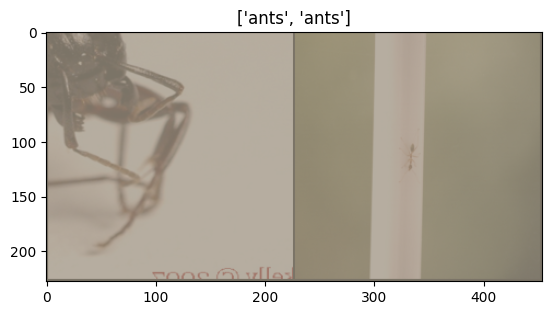

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(classes)
print(inputs.type())
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


We can now import CLIP from [Hugging Face](https://huggingface.co/).

In [ ]:
from transformers import CLIPProcessor, CLIPModel

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

The following function does the inference. It computes a similarity score between the input image and the texts "a photo of a ant" and the text "a photo of a bee." The function then returns the label (ant or bee) with the higher similarity score.

In [ ]:
def evalCLIP(image):
  inputs = processor(text=["a photo of a ant", "a photo of a bee"], images=image, return_tensors="pt", padding=True, do_rescale= False)
  outputs = model(**inputs)
  logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
  probs = logits_per_image.softmax(dim=1)
  indices =torch.max(probs,1)[1]
  return indices

If we test out CLIP over various batches, we see that it performs really well with an accuracy of 95%.

In [ ]:
num_batches = 20
running_loss = 0.0
running_corrects = 0

for batch in range(num_batches):
  inputs, labels = next(iter(dataloaders['train']))
  inputs = inputs.to(device)
  labels = labels.to(device)
  outputs = evalCLIP(inputs)
  running_corrects += torch.sum(outputs == labels.data)

print(running_corrects/(num_batches*2))


tensor(0.9500)
